# Pre processing

In [1]:
# --------------------------------------------------------------------------------------------------------
# Import necessary modules and libraries
# --------------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Daily
from datetime import datetime
import optuna

#Load data
data = pd.read_csv('/Users/admin/Documents/Formation ML Engineer/Projet SNCF/Data/X_train.csv')
target = pd.read_csv('/Users/admin/Documents/Formation ML Engineer/Projet SNCF/Data/y_train.csv')

# --------------------------------------------------------------------------------------------------------
# Data Preprocessing
# --------------------------------------------------------------------------------------------------------

# Convert 'date' column to datetime format and rename columns for clarity
data['date'] = pd.to_datetime(data['date'])
data = data.rename(columns={'ferie': 'holiday', 'vacances': 'school_holiday', 'job': 'work_day'})

# Create new date-based features (year, month, day, weekday)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.dayofweek

# Separate station code from the index of the target dataset
target['station'] = target['index'].str[-3:]
target['date'] = target['index'].str[:-4]
target['date'] = pd.to_datetime(target['date'])
target.set_index('date', inplace=True)
target = target.drop(columns=['index'])

# Merge target and feature dataframes based on 'date' and 'station'
merged_df = pd.merge(data, target, on=['date', 'station'], how='left')

# Pivot target values to wide format (one column per station)
pivoted_df = merged_df.pivot_table(index='date', columns='station', values='y')

# Identify first valid date for each station
first_valid_dates = pivoted_df.apply(lambda x: x.first_valid_index())

# Identify and filter out stations with anomaly in opening dates (for later processing)
anomaly_stations = first_valid_dates[(first_valid_dates >= '2015-01-31') & (first_valid_dates < '2022-01-01')]

# Filter out stations with insufficient data (opened in 2022 or later)
excluded_stations = first_valid_dates[first_valid_dates >= '2022-01-01']

# Manually mark TV1 as an anomaly due to insufficient data during test period
tv1_series = pd.Series({'TV1': first_valid_dates['TV1']})
anomaly_stations = pd.concat([anomaly_stations, tv1_series])

# Flatten the pivoted columns for easier access
pivoted_df.columns = [f'target_{station}' for station in pivoted_df.columns]

# Remove duplicates in exogenous data and drop station column
data_exog = data.drop(columns=['station']).drop_duplicates(subset='date')

# Merge exogenous variables and target data
final_df = pd.merge(pivoted_df, data_exog.set_index('date'), on='date')

# Set frequency for datetime index
final_df = final_df.asfreq('D')

# Separate target and exogenous variables from final dataset
final_target = final_df.filter(like='target_')
exog_vars = ['holiday', 'school_holiday', 'work_day', 'year', 'month', 'day', 'weekday']
final_exog = final_df[exog_vars]

# --------------------------------------------------------------------------------------------------------
# Generate weather data for training dataset using the Meteostat API
# --------------------------------------------------------------------------------------------------------

# Define the date range for weather data
start = datetime(2015, 1, 1)
end = datetime(2022, 12, 31)

# Create Point object for Paris (used for fetching weather data)
paris = Point(48.8566, 2.3522, 35)

# Fetch daily weather data for the defined time period
weather = Daily(paris, start, end).fetch()

# Drop unnecessary columns (either due to NaNs or irrelevance)
weather = weather.drop(columns=['tsun', 'pres', 'wpgt', 'wdir', 'tmin', 'tmax'])

# Fill missing values with 0 in weather columns of interest
columns_to_fill = ['tavg', 'prcp', 'snow', 'wspd']
weather[columns_to_fill] = weather[columns_to_fill].fillna(0)

# Reset the index of weather data and merge with exogenous variables
weather.reset_index(inplace=True)
weather['date'] = pd.to_datetime(weather['time'])
weather.drop(columns=['time'], inplace=True)
final_exog = pd.merge(final_exog, weather[['date', 'tavg', 'prcp', 'snow', 'wspd']], on='date', how='left')
final_exog.set_index('date', inplace=True)
final_exog = final_exog.asfreq('D')

## Vizualisations

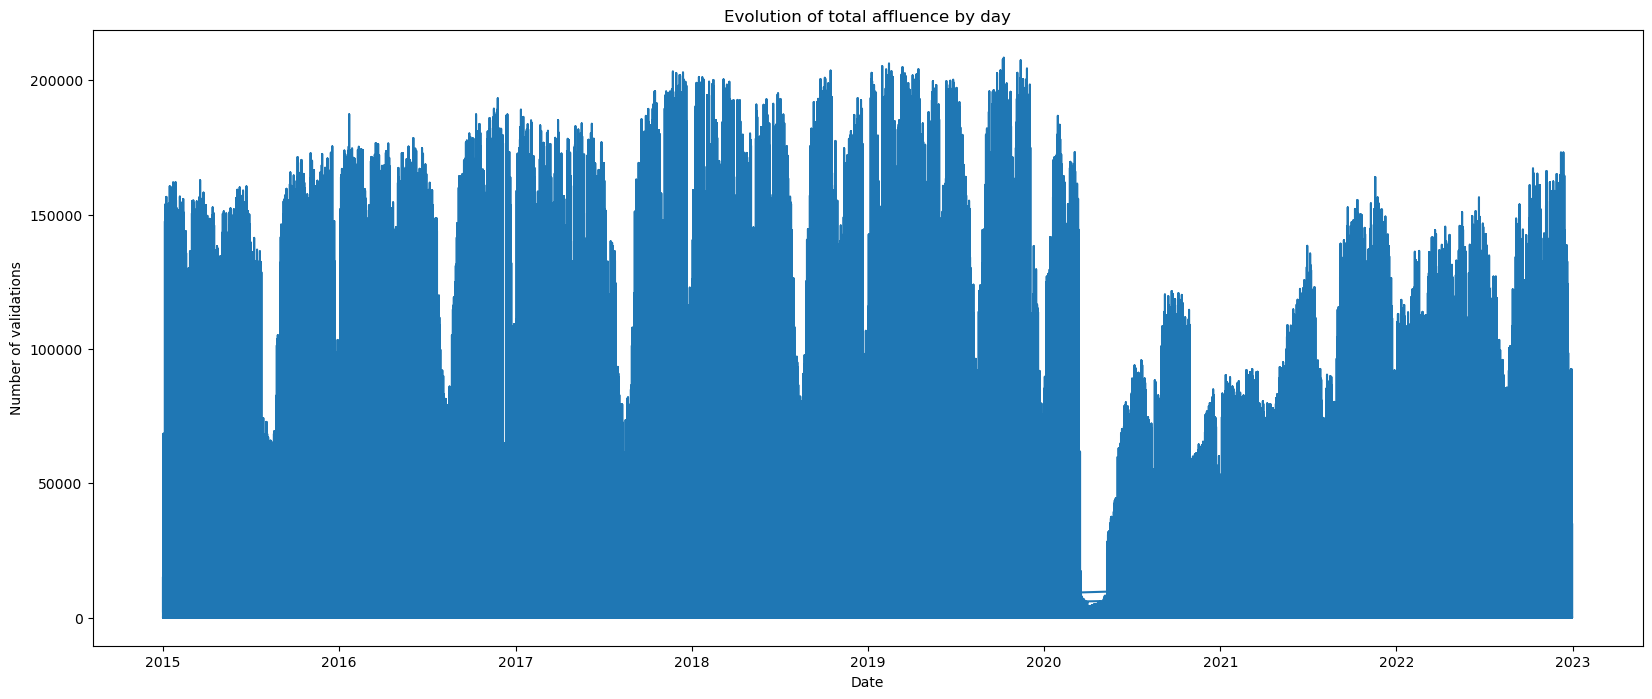

In [8]:
plt.figure(figsize = (20,8))
plt.plot(target.index, target.y)
plt.title('Evolution of total affluence by day')
plt.xlabel('Date')
plt.ylabel('Number of validations');

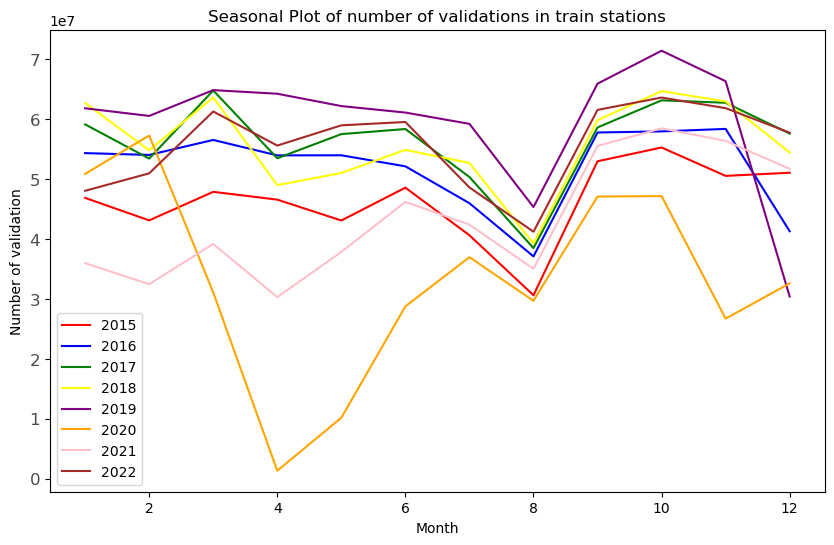

In [3]:
df_plot = target.copy()
df_plot['year'] = target.index.year
df_plot['month'] = target.index.month
df_plot

affluence_years = df_plot['year'].unique()

# Prep Colors
mycolors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown']

# Prep plot 
df_plot = df_plot.groupby(['year', 'month']).agg({'y':['sum']})
df_plot.columns = df_plot.columns.get_level_values(0)
df_plot = df_plot.reset_index()

# Draw Plot
plt.figure(figsize=(10,6))
for i, year in enumerate(affluence_years):
    to_plot = df_plot.loc[df_plot['year'] == year]
    plt.plot(to_plot.month, to_plot.y, color = mycolors[i], label=f'{year}')

plt.title("Seasonal Plot of number of validations in train stations")
plt.xlabel('Month')
plt.ylabel('Number of validation')
plt.yticks(fontsize=12, alpha=.7)
plt.legend()
plt.show()

In [10]:
merged_df

,date,station,work_day,holiday,school_holiday,year,month,day,weekday,y
0,2015-01-01,1J7,1,1,1,2015,1,1,3,7
1,2015-01-01,O2O,1,1,1,2015,1,1,3,0
2,2015-01-01,8QR,1,1,1,2015,1,1,3,9
3,2015-01-01,UMC,1,1,1,2015,1,1,3,9
4,2015-01-01,FK3,1,1,1,2015,1,1,3,28
...,...,...,...,...,...,...,...,...,...,...
1229858,2022-12-31,V2P,0,0,1,2022,12,31,5,1227
1229859,2022-12-31,N9K,0,0,1,2022,12,31,5,544
1229860,2022-12-31,P6E,0,0,1,2022,12,31,5,92
1229861,2022-12-31,BDC,0,0,1,2022,12,31,5,91


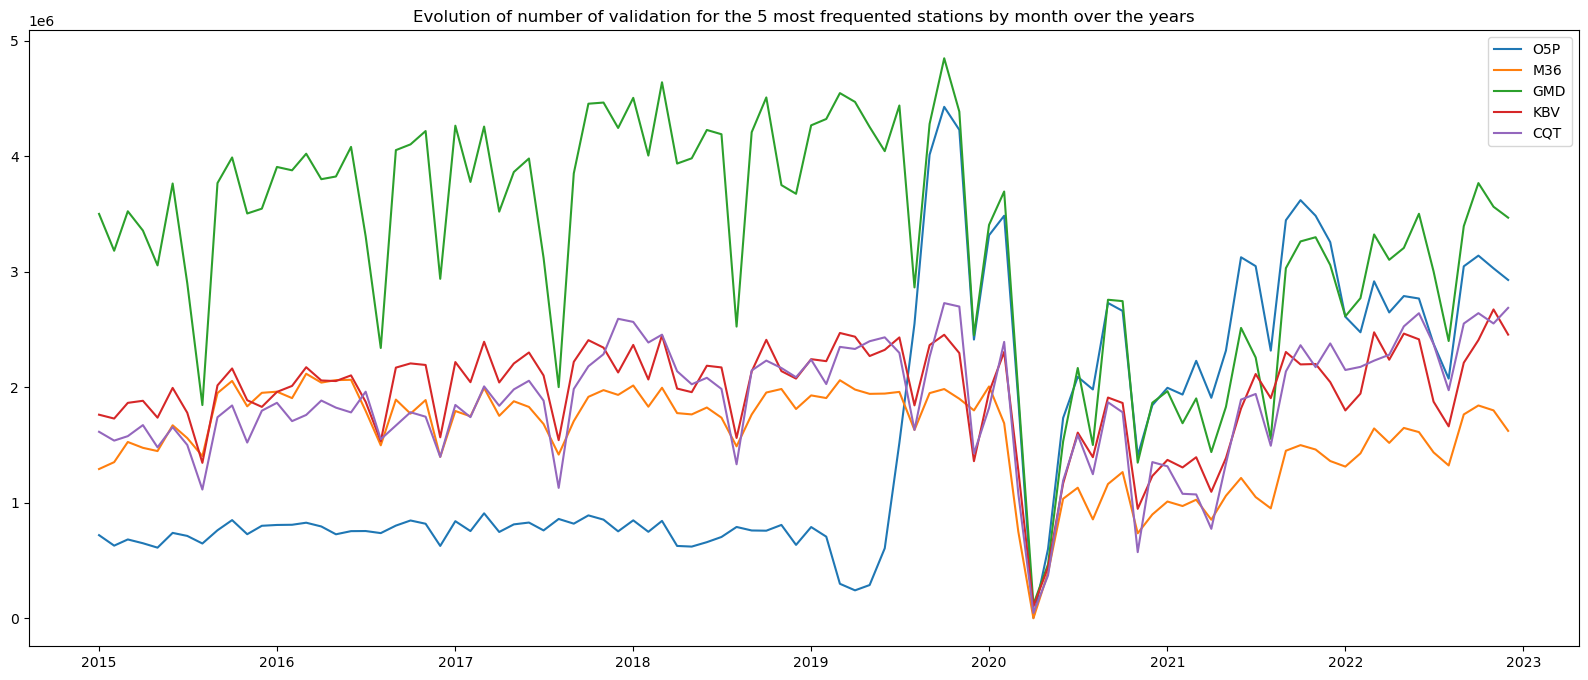

In [11]:
df_specific_station = merged_df[merged_df['station'].isin(['GMD', 'KBV', 'CQT', 'M36', 'O5P'])]
df_plot = df_specific_station.groupby(['station', 'year', 'month']).agg({'y':['sum']})
df_plot.columns = df_plot.columns.get_level_values(0)
df_plot = df_plot.reset_index()
df_plot['date'] = pd.to_datetime(df_plot['year'].astype('str') + '-' + df_plot['month'].astype('str') + '-01')

dif_station = df_specific_station['station'].unique()

plt.figure(figsize = (20,8))
for i in dif_station:
    plt.plot(df_plot[df_plot['station']==i].date, df_plot[df_plot['station']==i].y, label=f'{i}')
plt.title('Evolution of number of validation for the 5 most frequented stations by month over the years')
plt.legend();

In [6]:
df_pivoted = target[['station', 'y']].pivot(columns='station', values='y')
min_date = df_pivoted.apply(lambda col: col.first_valid_index())
opening_date = pd.DataFrame(min_date[min_date > "2015-01-08"])
opening_date = opening_date.rename({0: "Opening Date"}, axis = 1)
opening_date

,Opening Date
station,
48S,2017-07-02
BDC,2022-07-01
GW7,2015-11-16
N9K,2017-07-01
NEB,2015-01-26
OWM,2017-01-17
P6E,2022-07-01
QD6,2022-08-02
RF2,2015-03-15
